<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/labs/cs473_lab_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

# BYU CS 473 Lab Week 7

## Introduction:

For this lab, you will implement the Expectation Maximization algorithm on the Old Faithful dataset. This involves learning the parameters of a Gaussian mixture model. Your notebook should produce a visualization of the progress of the algorithm. The final figure could look something like this (they don't have to be arranged in subplots):

![final figure](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_7_image1.png)

---
## Grading standards   

Your notebook will be graded on the following:

* 10% Data is correctly mean-centered
* 20% Correctly updates responsibilities
* 20% Correctly updates means
* 20% Correctly updates covariances
* 20% Correctly updates mixing weights
* 10% Final plot(s) is/are tidy and legible

---
## Description

For this lab, we will be using the Expectation Maximization (EM) method to learn the parameters of a Gaussian mixture model. These parameters will reflect cluster structure in the data – in other words, we will learn probabilistic descriptions of clusters in the data.

For this lab, you will use the Old Faithful dataset, which you can download here:

[Old Faithful dataset](https://wingated.github.io/cs473/data/old_faithful.csv)

When loading the dataset, you should mean center the data to avoid division by zero in later steps.

The equations for implementing the EM algorithm are given in MLAPP 8.7.

The algorithm is:

1. Compute the responsibilities $r_nk$ (Eq. 8.160)
2. Update the mixing weights $\pi_k$ (Eq. 8.167)
3. Update the covariances $\Sigma_k$ (Eq. 8.166)
4. Update the means $\mu_k$ (Eq. 8.165)

Now, repeat until convergence. Note that if you change the order of operations, you may get slightly difference convergences than the reference image.

Since the EM algorithm is deterministic, and since precise initial conditions for your algorithm are given below, the progress of your algorithm should closely match the reference image shown above.

For your visualization, please print out at least nine plots. These should color each datapoint using $r_ik$ and they should plot the means and covariances of the Gaussians. See the hints section for how to plot an ellipse representing the 95% confidence interval of a Gaussian, given an arbitrary covariance matrix.

**Note: To help our TA better grade your notebook, you should use the following initial parameters:**

```python
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])

# the Gaussian covariance matrices
covs = list()
covs.append(
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append(
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )

# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called pi in the book
```

---
## Hints

In order to visualize a covariance matrix, you should plot an ellipse representing the 95% confidence bounds of the corresponding Gaussian. Here is some code that accepts as input a covariance matrix, and returns a set of points that define the correct ellipse; these points can be passed directly to the plt.plot() command as the x and y parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

colors = ['blue', 'green']


def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )


def compute_responsibilities(X, mus, covs, mws):
    N, K = X.shape[0], len(mws)
    r = np.zeros((N, K))
    for k in range(K):
        r[:, k] = mws[k] * scipy.stats.multivariate_normal.pdf(X, mean=mus[k], cov=covs[k])
    r /= np.sum(r, axis=1, keepdims=True)
    return r


def update_parameters(X, r):
    N, D = X.shape
    K = r.shape[1]
    Nk = np.sum(r, axis=0)

    mus = np.zeros((K, D))
    covs = []
    mws = Nk / N

    for k in range(K):
        mus[k] = np.sum(r[:, k][:, np.newaxis] * X, axis=0) / Nk[k]
        diff = X - mus[k]
        cov = (r[:, k][:, np.newaxis, np.newaxis] *
               np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk[k]
        covs.append(cov)

    return mus, covs, mws


def log_likelihood(X, mus, covs, mws):
    N, K = X.shape[0], len(mws)
    probs = np.zeros((N, K))
    for k in range(K):
        probs[:, k] = mws[k] * scipy.stats.multivariate_normal.pdf(X, mean=mus[k], cov=covs[k])
    return np.sum(np.log(np.sum(probs, axis=1)))


def plot(X, r, it):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=r[:, 0], s=10, cmap='gray', edgecolor='k', linewidth=0.5)

    # Plot covariance ellipses
    for k in range(len(covs)):
        plt.scatter(mus[k, 0], mus[k, 1], color=colors[(k) % len(colors)], marker='*', s=100, label=f'Group {k + 1}')

        pts = cov_to_pts(covs[k]).T + mus[k]
        plt.plot(pts[:, 0], pts[:, 1], color=colors[k % len(colors)], linewidth=2)

    plt.title(f"Iteration {it}")
    plt.xlabel("Eruption Time Difference")
    plt.ylabel("Waiting Time Difference")
    plt.legend()
    plt.xlim(-3, 3)
    plt.ylim(-40, 40)
    plt.show()

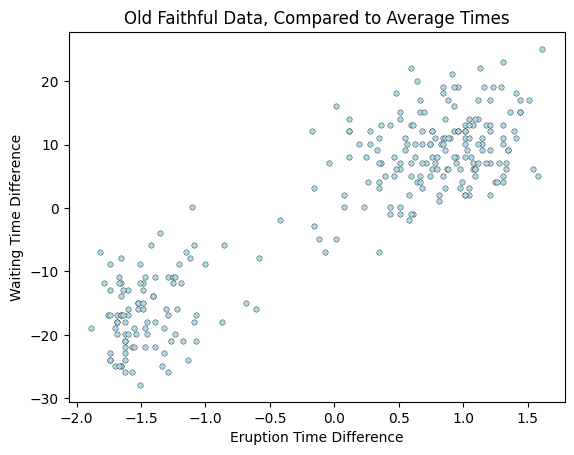

In [2]:
# Load the dataset with headers
data = pd.read_csv("old_faithful.csv")

# Extract just the numerical columns
X = data[["TimeEruption", "TimeWaiting"]].values

# Mean-center the data
X = X - np.mean(X, axis=0)

# visualize data
plt.scatter(X[:, 0], X[:, 1], s=15, color="lightblue", edgecolor='k', linewidth=0.25)
plt.title("Old Faithful Data, Compared to Average Times")
plt.xlabel("Eruption Time Difference")
plt.ylabel("Waiting Time Difference")
plt.show()

Iteration 0, log-likelihood: -1291.6961


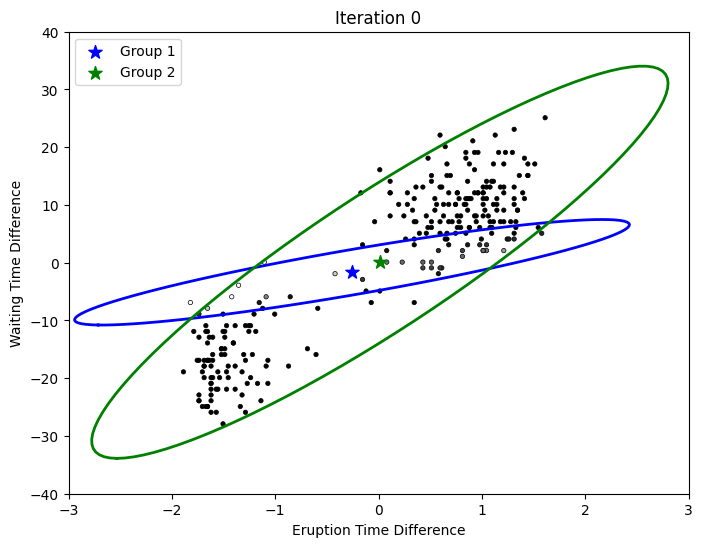


Iteration 5, log-likelihood: -1277.0728
Iteration 10, log-likelihood: -1269.3002


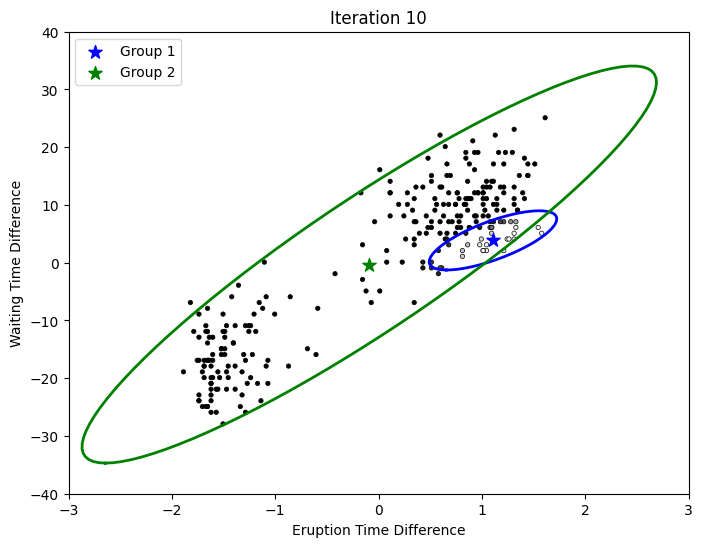


Iteration 15, log-likelihood: -1247.6858
Iteration 20, log-likelihood: -1215.6799


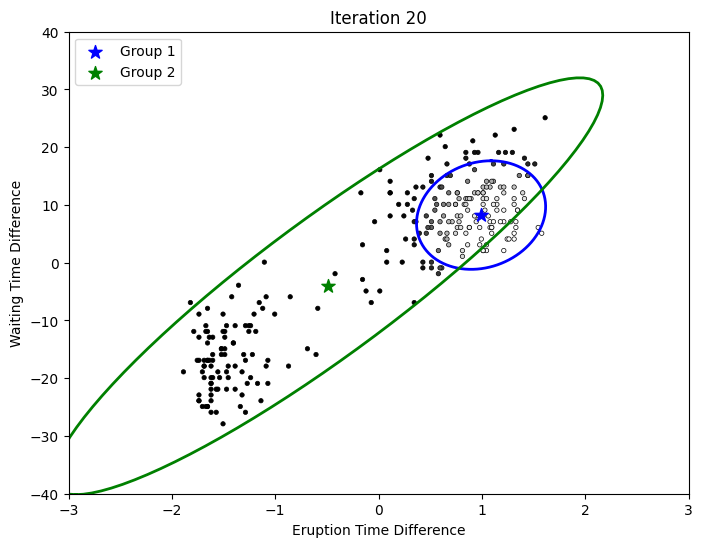


Iteration 25, log-likelihood: -1195.9373
Iteration 30, log-likelihood: -1153.5822


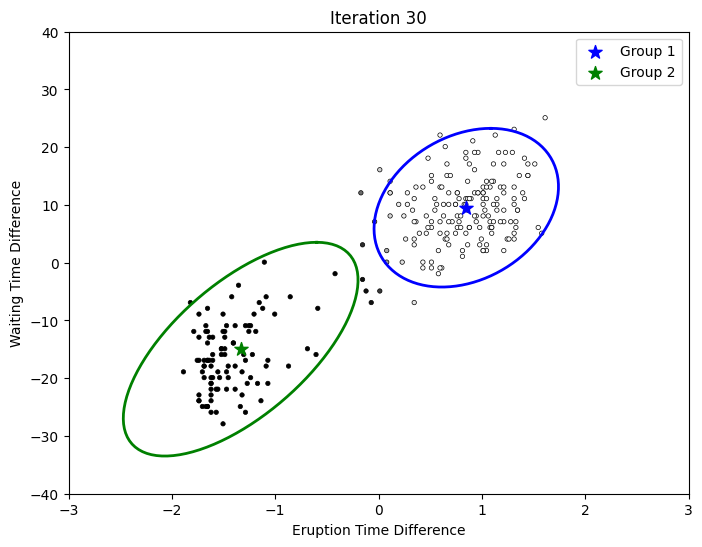


Iteration 35, log-likelihood: -1130.2641
Converged at iteration 39


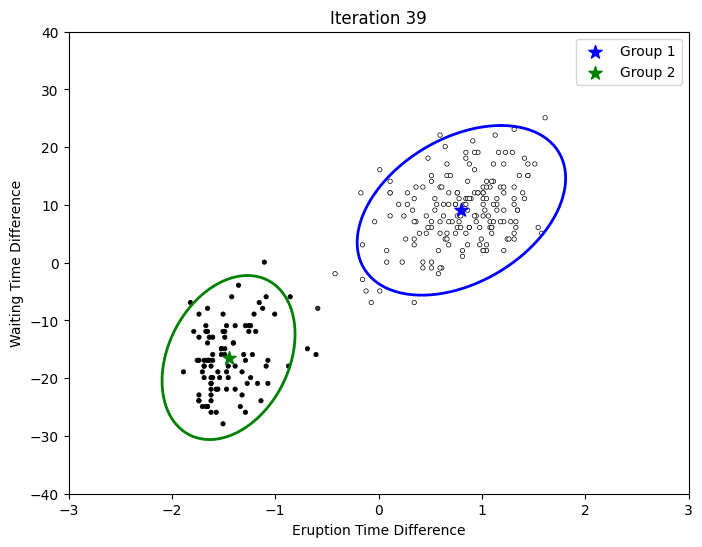

In [3]:
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])

# the Gaussian covariance matrices
covs = list()
covs.append(
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append(
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )

# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called pi in the book

log_likelihoods = []
it = 0

# repeat until convergence
while it < 2 or abs(log_likelihoods[-1] - log_likelihoods[-2]) >= 1e-6:
    # E-step
    r = compute_responsibilities(X, mus, covs, mws)

    # M-step
    mus, covs, mws = update_parameters(X, r)

    # Compute log-likelihood
    ll = log_likelihood(X, mus, covs, mws)
    log_likelihoods.append(ll)

    if it % 10 == 0 or it == 99:
        print(f"Iteration {it}, log-likelihood: {ll:.4f}")
        plot(X, r, it)
        print()

    elif it % 5 == 0:
        print(f"Iteration {it}, log-likelihood: {ll:.4f}")

    it += 1

print(f"Converged at iteration {it}")
plot(X, r, it)